In [1]:
# %pip install nltk

In [2]:
# !pip install -U yellowbrick

In [3]:
import sys
import pandas as pd
import re
import nltk
from operator import add
from pyspark.sql import SparkSession
from pyspark.ml.feature import StopWordsRemover
import pyspark.sql.functions as f
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
# from nltk.corpus import stopwords


In [4]:
spark = SparkSession\
  .builder \
  .appName("PythonWordCount") \
  .getOrCreate()


# # Read CSV from OVHcloud Object Storage https://github.com/walkerkq/musiclyrics
# data = spark.read.format('json').options(header='true', inferSchema='true') \
#   .load('hip_hop_lyrics.json', sep=",", header=True) \

data = spark.read.option("multiline","true").json('hipHop_romance_lyrics.json')
data.select("Lyrics").show()
print('############ JSON extract:')
data.show()


+--------------------+
|              Lyrics|
+--------------------+
|Ah, skru' op for ...|
|[Queen Heroin]
As...|
|Tell the DJ Turn ...|
|[Verse 1: Yowda]
...|
|        INSTRUMENTAL|
|[Produced by Rash...|
|[Vers 1: Node]
So...|
|[Produced by DJ M...|
|[Verse 1: Dr. Dre...|
|[Intro: 2Pac]
Big...|
|Tsunami, drop!
Dr...|
|4/1
Ariana Grande...|
|[Chorus: Lloyd Ba...|
|[Letra de "Gasoli...|
|[Intro]
Shake dat...|
|Mein kopf der spe...|
|3/2
Deko - Moonki...|
|Return to clone m...|
|Emergency call th...|
|It's me bitches
S...|
+--------------------+
only showing top 20 rows

############ JSON extract:
+---------------+--------------------+--------------------+
|         Artist|              Lyrics|               Title|
+---------------+--------------------+--------------------+
|         Marwan|Ah, skru' op for ...|        ButterBombay|
|Various Artists|[Queen Heroin]
As...|             Jumanji|
|    Yellow Claw|Tell the DJ Turn ...|       DJ Turn It Up|
|          Yowda|[Verse 1: Yowda]
.

In [5]:
# Tokenize DataFrame
data = Tokenizer(inputCol="Lyrics", outputCol="Words")

In [6]:
df=pd.read_json ('hipHop_romance_lyrics.json',)

In [7]:
df.Lyrics=df.Lyrics.replace('\n', ' ')


df.head()

,Title,Artist,Lyrics
0,ButterBombay,Marwan,"Ah, skru' op for lortet mayn\nYeah\nVi' ind' i..."
1,Jumanji,Various Artists,"[Queen Heroin]\nAsides from gettin in you, the..."
2,DJ Turn It Up,Yellow Claw,Tell the DJ Turn It Up\nTell the DJ bring it b...
3,Shut Up (feat. Y.G.),Yowda,"[Verse 1: Yowda]\nYou ain't talk about money ,..."
4,Afterdark,Joel Fletcher,INSTRUMENTAL


In [8]:
df.Lyrics=df.Lyrics.str.lower()

df.head()

,Title,Artist,Lyrics
0,ButterBombay,Marwan,"ah, skru' op for lortet mayn\nyeah\nvi' ind' i..."
1,Jumanji,Various Artists,"[queen heroin]\nasides from gettin in you, the..."
2,DJ Turn It Up,Yellow Claw,tell the dj turn it up\ntell the dj bring it b...
3,Shut Up (feat. Y.G.),Yowda,"[verse 1: yowda]\nyou ain't talk about money ,..."
4,Afterdark,Joel Fletcher,instrumental


In [9]:
s = '[verse 1]\n'
# df.Lyrics=df.Lyrics.lstrip('[verse 1]\n')
df.Lyrics=df.Lyrics.map(lambda x: x.lstrip(s))

In [11]:
import nltk
from nltk.corpus import stopwords
# print(stopwords.words('english'))

In [12]:
df.Lyrics=df.Lyrics.apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

In [13]:
def identify_tokens(row):
    review = row['Lyrics']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

df['Lyrics'] = df.apply(identify_tokens, axis=1)

In [14]:
stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row['Lyrics']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)



df['Lyrics'] = df.apply(remove_stops, axis=1)

In [15]:
stops = set(['chorus', 'verse', 'de', 'na', 'ne', 'wan'])                 

def remove_stops(row):
    my_list = row['Lyrics']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)



df['Lyrics'] = df.apply(remove_stops, axis=1)

In [16]:

# Let's evaluate the POS tags for our test set data
tagged_stanzas_test = []
tagged_test = []

for word in df['Lyrics']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_test.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_test.append(tagged_stanzas_test)

In [17]:
# Let's evaluate the POS tags for our train set data
tagged_stanzas_train = []
tagged_train = []

for word in df['Lyrics']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_train.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_train.append(tagged_stanzas_train)

In [18]:
from yellowbrick.text import PosTagVisualizer
%matplotlib inline
from matplotlib import pyplot as plt
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette
from yellowbrick.style import set_palette


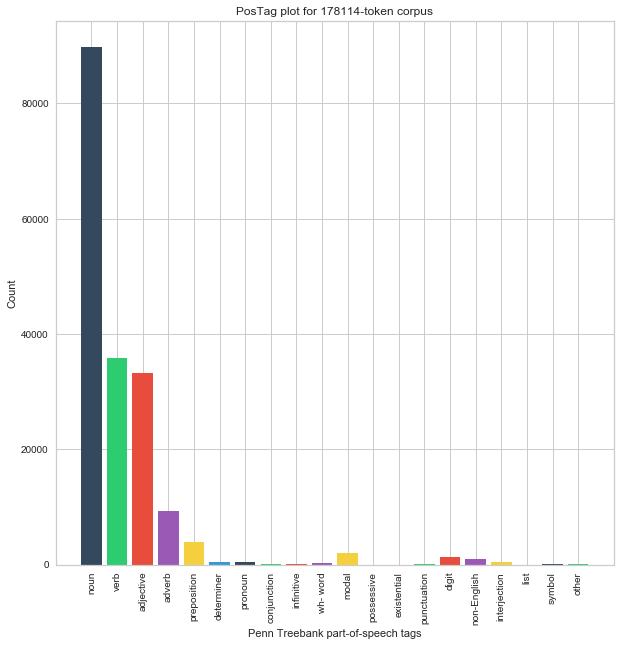

In [19]:
set_palette('flatui')
plt.figure(figsize=(10,10))
viz = PosTagVisualizer()
viz.fit(tagged_train)
viz.show()

In [20]:
# df['Lyrics'] = df['Lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# df.Lyrics.head()

In [29]:
import seaborn as sns
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    # new= text.str.split()
    new=text
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(10,10))
    # sns.set_theme(style="whitegrid")
    # sns.color_palette("viridis")
    sns.barplot(x=y,y=x, palette="deep")

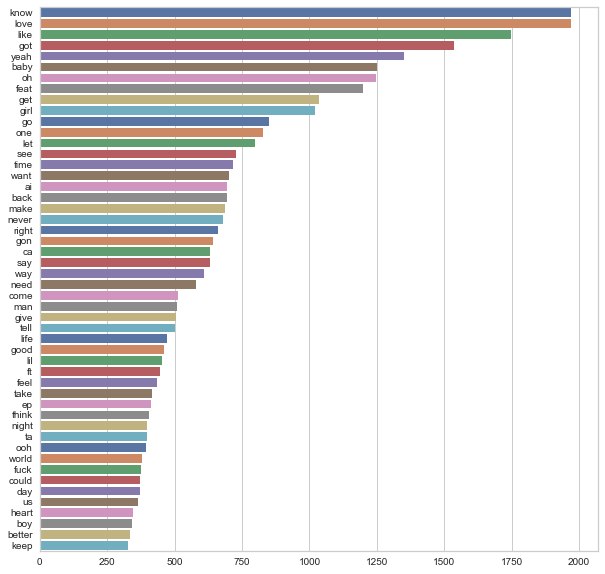

In [30]:
plot_top_non_stopwords_barchart(df['Lyrics'])

In [25]:
df.Lyrics.to_csv(
    'hip_hop.csv', index=True
)

In [26]:
data = spark.read.format('csv').options(header='true', inferSchema='true') \
  .load('hip_hop.csv') \
    

In [27]:
data.show()

+---+--------------------+
|_c0|              Lyrics|
+---+--------------------+
|  0|['ah', 'skru', 'o...|
|  1|['queen', 'heroin...|
|  2|['tell', 'dj', 't...|
|  3|['yowda', 'ai', '...|
|  4|    ['instrumental']|
|  5|['produced', 'ras...|
|  6|['node', 'som', '...|
|  7|['produced', 'dj'...|
|  8|['dr', 'dre', 'kn...|
|  9|['intro', 'big', ...|
| 10|['tsunami', 'drop...|
| 11|['ariana', 'grand...|
| 12|['lloyd', 'banks'...|
| 13|['letra', 'gasoli...|
| 14|['intro', 'shake'...|
| 15|['mein', 'kopf', ...|
| 16|['deko', 'moonkid...|
| 17|['turn', 'clone',...|
| 18|['mergency', 'cal...|
| 19|['bitches', 'show...|
+---+--------------------+
only showing top 20 rows



In [28]:
data.withColumn('word', f.explode(f.split(f.col('Lyrics'), ' '))) \
  .groupBy('word') \
  .count() \
  .sort('count', ascending=False) \
  .show()


+--------+-----+
|    word|count|
+--------+-----+
| 'know',| 1961|
| 'love',| 1951|
| 'like',| 1742|
|  'got',| 1530|
| 'yeah',| 1326|
|   'oh',| 1233|
| 'baby',| 1231|
| 'feat',| 1198|
|  'get',| 1031|
| 'girl',| 1011|
|   'go',|  844|
|  'one',|  823|
|  'let',|  795|
|  'see',|  727|
| 'time',|  712|
| 'want',|  695|
|   'ai',|  695|
| 'back',|  689|
| 'make',|  685|
|'never',|  677|
+--------+-----+
only showing top 20 rows

